In [7]:
import mlflow
import boto3
import awscli

In [8]:
mlflow.set_tracking_uri("http://ec2-3-107-229-149.ap-southeast-2.compute.amazonaws.com:5000/")


In [11]:
mlflow.set_experiment("Exp2 BoW VS TFIdf")

2025/12/13 04:45:53 INFO mlflow.tracking.fluent: Experiment with name 'Exp2 BoW VS TFIdf' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://sentiment-analysis-bucket-alqud/mlflow-artifacts/3', creation_time=1765561552301, experiment_id='3', last_update_time=1765561552301, lifecycle_stage='active', name='Exp2 BoW VS TFIdf', tags={}>

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [13]:
df= pd.read_csv("reddit_prepocessing.csv").dropna(subset=["clean_comment"])

2025/12/13 04:46:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Accuracy: 0.6478930860493659
🏃 View run BoW_(1, 1)_RandomForest at: http://ec2-3-107-229-149.ap-southeast-2.compute.amazonaws.com:5000/#/experiments/3/runs/0a2e201c60ec4889aedeb234d15ffea6
🧪 View experiment at: http://ec2-3-107-229-149.ap-southeast-2.compute.amazonaws.com:5000/#/experiments/3


2025/12/13 04:46:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Accuracy: 0.6483021955543434
🏃 View run TF-IDF_(1, 1)_RandomForest at: http://ec2-3-107-229-149.ap-southeast-2.compute.amazonaws.com:5000/#/experiments/3/runs/4ff27fd7c1104a78b12ea25cf1bf6b06
🧪 View experiment at: http://ec2-3-107-229-149.ap-southeast-2.compute.amazonaws.com:5000/#/experiments/3


2025/12/13 04:47:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Accuracy: 0.6511659620891859
🏃 View run BoW_(1, 2)_RandomForest at: http://ec2-3-107-229-149.ap-southeast-2.compute.amazonaws.com:5000/#/experiments/3/runs/cac6c25835574c6fbc2e9310c5e83a4d
🧪 View experiment at: http://ec2-3-107-229-149.ap-southeast-2.compute.amazonaws.com:5000/#/experiments/3


2025/12/13 04:48:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Accuracy: 0.6536206191190509
🏃 View run TF-IDF_(1, 2)_RandomForest at: http://ec2-3-107-229-149.ap-southeast-2.compute.amazonaws.com:5000/#/experiments/3/runs/f6afea6098c843ad9e845e790f21fb06
🧪 View experiment at: http://ec2-3-107-229-149.ap-southeast-2.compute.amazonaws.com:5000/#/experiments/3


2025/12/13 04:48:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Accuracy: 0.6525296604391109
🏃 View run BoW_(1, 3)_RandomForest at: http://ec2-3-107-229-149.ap-southeast-2.compute.amazonaws.com:5000/#/experiments/3/runs/3f982c618be64da69dd28190a9d91344
🧪 View experiment at: http://ec2-3-107-229-149.ap-southeast-2.compute.amazonaws.com:5000/#/experiments/3


2025/12/13 04:49:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Accuracy: 0.6528024001090958
🏃 View run TF-IDF_(1, 3)_RandomForest at: http://ec2-3-107-229-149.ap-southeast-2.compute.amazonaws.com:5000/#/experiments/3/runs/8a93bc19ea8b44bc9f6a458afc2295a3
🧪 View experiment at: http://ec2-3-107-229-149.ap-southeast-2.compute.amazonaws.com:5000/#/experiments/3


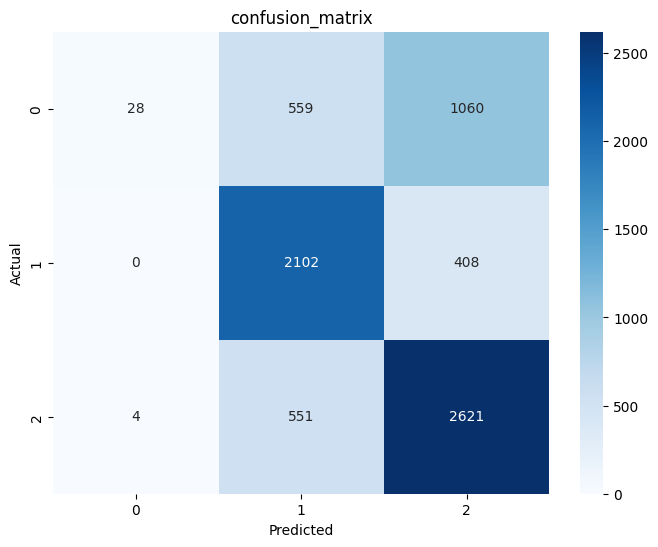

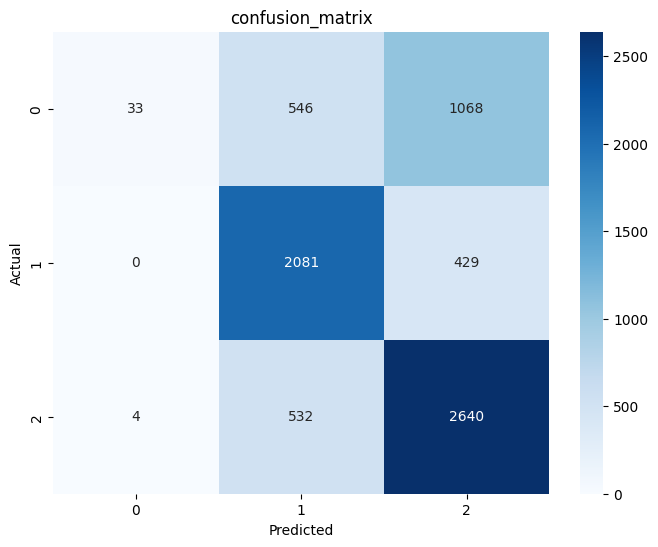

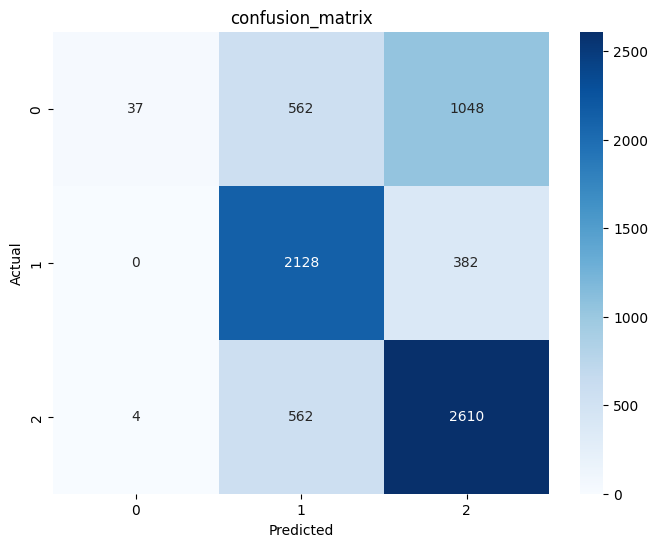

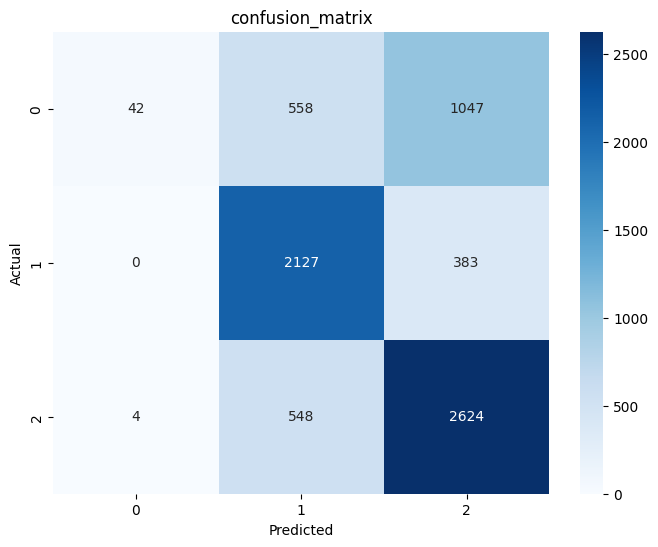

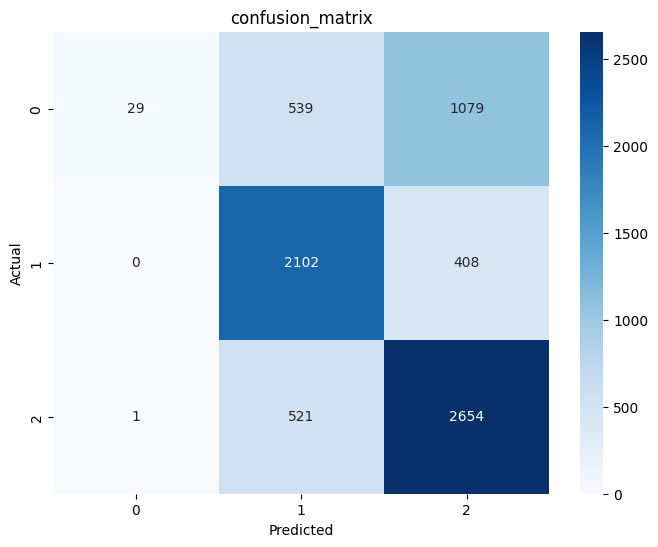

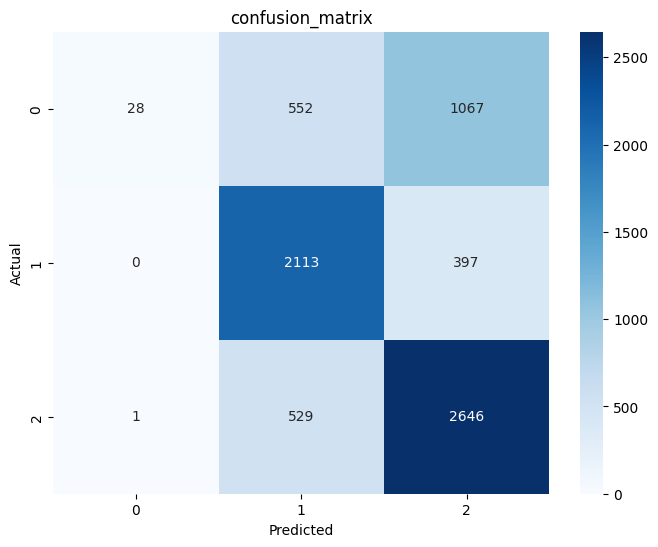

In [14]:
def run_experiment(vectorizer_type,ngram_range,vectorizer_max_features,vectorizer_name):
    if vectorizer_name=="BoW":
        vectorizer = CountVectorizer(ngram_range=ngram_range,max_features=vectorizer_max_features)
    else:
        vectorizer= TfidfVectorizer(ngram_range=ngram_range,max_features=vectorizer_max_features)
    
    X_train,X_test,y_train,y_test = train_test_split(df["clean_comment"],df['category'],test_size=0.2,random_state=42)

    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    with mlflow.start_run() as run:
        mlflow.set_tag("mlflow.runName",f"{vectorizer_name}_{ngram_range}_RandomForest")
        mlflow.set_tag("experiment_type", "feature_engineering")
        mlflow.set_tag("model_type", "RandomForestClassifier")

        mlflow.set_tag("description",f"RandomForest with {vectorizer_name} ngram={ngram_range}, max_features={vectorizer_max_features}")

        mlflow.log_param("vectorizer_type",vectorizer_type)
        mlflow.log_param("ngram_range",ngram_range)

        mlflow.log_param("vectorizer_max_features",vectorizer_max_features)

        n_estimators =200
        max_depth=15

        mlflow.log_param("n_estimators",n_estimators)
        mlflow.log_param("max_depth",max_depth)

        model = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,random_state=42)
        model.fit(X_train,y_train)

        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test,y_pred)
        mlflow.log_metric("accuracy",accuracy)

        classification_rep = classification_report(y_test,y_pred,output_dict=True)

        for label, metrics in classification_rep.items():
            if isinstance(metrics,dict):
                for metric ,value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}",value)

        conf_matrix = confusion_matrix(y_test,y_pred)
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_matrix,annot=True,fmt="d",cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("confusion_matrix")

        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
        

        mlflow.sklearn.log_model(model,f"random_forest_model_{vectorizer_name}_{ngram_range}")



        print(f"Accuracy: {accuracy}")

ngram_ranges = [(1,1),(1,2),(1,3)]
max_features =5000

for ngram_range in ngram_ranges:
    run_experiment("Bow",ngram_range=ngram_range,vectorizer_max_features=max_features,vectorizer_name="BoW")

    run_experiment("TF_IDF",ngram_range,max_features,vectorizer_name="TF-IDF")



